In [1]:
import os
import glob
import pickle
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def azimuthal_average(img, center=None):
    # get indicies of image
    y, x = np.indices(img.shape)
    
    # initialize center
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    radius = np.hypot(x - center[0], y - center[1])

    # sort the radii
    idx = np.argsort(radius.flat)
    radius_sorted = radius.flat[idx]
    idx_sorted = img.flat[idx]

    # convert the radii into int
    radius = radius_sorted.astype(int)

    # locate pixels that fall under each radial bin
    del_r = radius[1:] - radius[:-1]
    radius_idx = np.where(del_r)[0]
    radius_bin = radius_idx[1:] - radius_idx[:-1]
    
    # find the sum of each radius bin
    csum = np.cumsum(idx_sorted, dtype=float)
    sum_bin = csum[radius_idx[1:]] - csum[radius_idx[:-1]]

    radial_profile = sum_bin / radius_bin

    return radial_profile

In [3]:
path = ['faces/fake', 'faces/real']
labels = [1,0]
format_file = ['jpg','jpg']
epsilon = 1e-8
data = {}

#number of samples from each dataset
sample_size = 2500
i = 4 * sample_size
final_power_spectrum = np.zeros([i, 722])
final_label = np.zeros([i])
curr_iter = 0

In [4]:
for z in range(2):
    count = 0
    avg_power_spectrum = np.zeros(722)
    print(f"Processing... {path[z]}")
    
    for filename in glob.glob(path[z]+"/*."+format_file[z]):  
        img = cv2.imread(filename,0)
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon

        magnitude_spectrum = 20*np.log(np.abs(fshift))

        # find azimuthal average
        psd1D = azimuthal_average(magnitude_spectrum)
        final_power_spectrum[curr_iter,:] = psd1D
        final_label[curr_iter] = labels[z]

        count+=1
        curr_iter+=1
        if count >= sample_size:
            break

data["power_spectrum"] = final_power_spectrum
data["label"] = final_label

output = open('power_spectrum_10000.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("Done!")

Processing... faces/fake
Processing... faces/real
Done!


# Train Test Split

In [5]:
# load pkl file
pkl_file = open('power_spectrum_10000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["power_spectrum"]
y = data["label"]

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=27)

# Model Pipeline

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [8]:
# model pipeline
pipeline = []

pipeline.append(LogisticRegression(solver='liblinear'))
pipeline.append(SVC())
pipeline.append(KNeighborsClassifier())
pipeline.append(DecisionTreeClassifier())
pipeline.append(RandomForestClassifier())
pipeline.append(GaussianNB())

# Model Evaluation

In [9]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [10]:
models_list = ['Logistic Regression', 'SVM', 'KNN', 'Decision Tree', 'Raandom Forest', 'Naive Bayes']

acc_list = []
auc_list = []
cm_list = []

for model in pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
    auc_list.append(round(metrics.auc(fpr, tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))

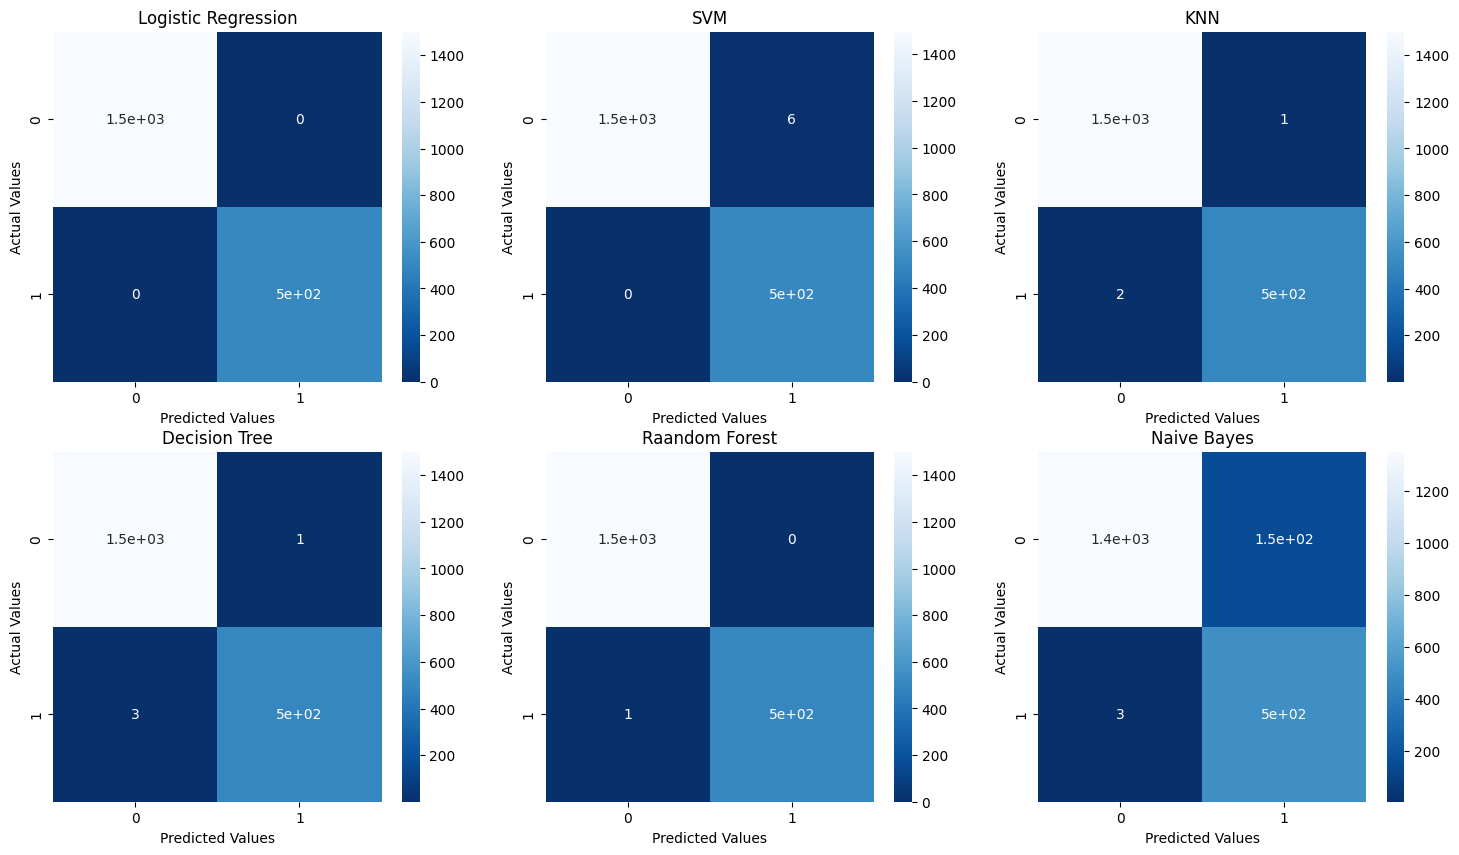

In [11]:
fig = plt.figure(figsize=(18,10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = models_list[i]
    
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True, cmap='Blues_r')
    cm_plot.set_xlabel("Predicted Values")
    cm_plot.set_ylabel("Actual Values")

In [12]:
# accuracy and auc
result = pd.DataFrame({'Model': models_list, 'Accuracy': acc_list, 'AUC': auc_list})

In [13]:
result

,Model,Accuracy,AUC
0,Logistic Regression,1.0000,1.00
1,SVM,0.9970,1.00
2,KNN,0.9985,1.00
3,Decision Tree,0.9980,1.00
4,Raandom Forest,0.9995,1.00
5,Naive Bayes,0.9235,0.95
